### Question 1-4 of Group Submission 2 of Group -14

#### Import all the required packages

In [17]:
import numpy as np
from scipy.stats import norm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import ncx2

### Question 1: Pricing a vanilla European Call option

Given parameters

In [18]:
#share specific information
S0 = 100
v0 = 0.06
kappa = 9
theta = 0.06
r = 0.08
sigma = 0.3
rho = -0.4

#Call option specific information
K = 100
T = 1
k_log = np.log(K)

#Approximation information
t_max = 30
N = 100

In [19]:
# Characteristic function code
a = sigma**2/2

def b(u):
    return kappa - rho*sigma*1j*u

def c(u):
    return -(u**2+1j*u)/2

def d(u):
    return np.sqrt(b(u)**2-4*a*c(u))

def xminus(u):
    return (b(u)-d(u))/(2*a)

def xplus(u):
    return (b(u)+d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u + theta*kappa*val1

def D(u):
    val1 = 1-np.exp(-T*d(u))
    val2 = 1-g(u)*np.exp(-T*d(u))
    return (val1/val2)*xminus(u)

def log_char(u):
    return np.exp(C(u) + D(u)*v0 + 1j*u*np.log(S0))

def adj_char(u):
    return log_char(u-1j)/log_char(-1j)

In [20]:
delta_t = t_max/N
from_1_to_N = np.linspace(1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

In [21]:
first_integral = sum((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t)
second_integral = sum((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t)

In [22]:
fourier_call_val = S0*(1/2 + first_integral/np.pi)-np.exp(-r*T)*K*(1/2 + second_integral/np.pi)
print(fourier_call_val)

13.734895692109049


### Question 2: Simulate share price path using CEV model

In [23]:
# other parameters are declared above
gamma = 0.75
dt = 1/12

def share_price_path(t, N):
    n = int(t/dt)
    Z = norm.rvs(size =[N, n])
    price_path = np.array([[np.float64(S0)]*(n+1)]*N)
    for i in range(n):
        vol = sigma*price_path[:,i]**(gamma-1)
        power = (r-vol**2/2)*dt+vol*np.sqrt(dt)*Z[:,i]
        price_path[:,i+1]=price_path[:,i]*np.exp(power)
    return price_path

In [24]:
# defining the seed
np.random.seed(10)

# sample price path with various sample size
share_price_T = [None]*50
vol_share = [None]*50

for i in range(1,51):
    samples = share_price_path(T, i*1000)
    share_price_T[i-1] = np.mean(samples[:,-1])
    vol_share[i-1] = np.std(samples[:, -1])/np.sqrt(i*1000)

All the sample paths for each case is defined in samples variable. The size of the sample variable for each case is an array of [N x 12]

And the mean value is calcualted for each case of N using the above samples to get the price at T and stored in the share_price_T variable

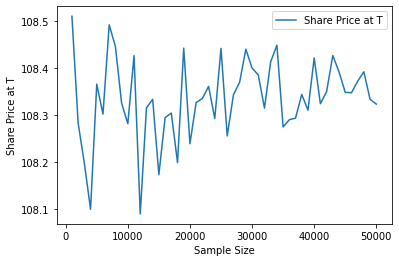

In [25]:
plt.plot(np.array(range(1,51))*1000, share_price_T, label="Share Price at T")
plt.xlabel('Sample Size')
plt.ylabel('Share Price at T')
plt.legend()
plt.show()

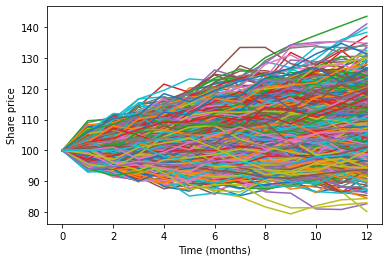

In [35]:
# visualising 1000 share price paths as an example

paths_1000 = share_price_path(1, 1000)

for array in paths_1000:
    plt.plot(array)

plt.xlabel('Time (months)')
plt.ylabel('Share price')
plt.show()

### Question 3. Price of Vanilla call option - simulate Monte Carlo estimates

In [27]:
# Set the random seed as above to reproduce the result
np.random.seed(10)

# use the above defined CEV model function.
def call_price_and_stddev(t, N):
    sample = share_price_path(t, N)
    pay_off = np.maximum(sample[:, -1]-K, 0)*np.exp(-r*t)
    return np.mean(pay_off), np.std(pay_off)/np.sqrt(N)

In [28]:
#Price calculation
call_price = [None]*50
call_stddev = [None]*50

# price estimates
for i in range(1, 51):
    call_price[i-1], call_stddev[i-1] = call_price_and_stddev(T, i*1000)

In [29]:
# Call price under closed form and the method is CEV
z = 2+1/(1-gamma)
def closed_form_call_price(t):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-ncx2.cdf(y,z,x))-K*np.exp(-r*t)*ncx2.cdf(x,z-2,y)

### Question 4. Plot the above results and error bounds of the estimates

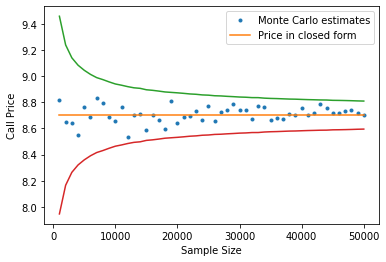

In [30]:
# plots - call option price od estimates and in clsoed -form CEV, and error bounds
plt.plot(np.array(range(1,51))*1000, call_price, '.', label="Monte Carlo estimates")
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)]*50, label="Price in closed form")
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)+3*s for s in call_stddev])
plt.plot(np.array(range(1,51))*1000, [closed_form_call_price(T)-3*s for s in call_stddev])
plt.xlabel("Sample Size")
plt.ylabel("Call Price")
plt.legend()
plt.show()

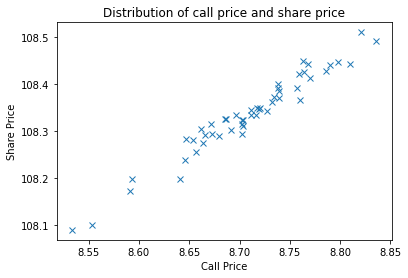

In [31]:
# Distribution graph of call_price and estimated share price
plt.plot(call_price, share_price_T, 'x')
plt.xlabel("Call Price")
plt.ylabel("Share Price")
plt.title("Distribution of call price and share price")
plt.show()

Check the correlation coefficient of the above graph

In [32]:
corr, _ = pearsonr(call_price, share_price_T)

In [33]:
corr

0.976096807863086